# Анализ тональности текстов.

## Устанавливаем и импортируем необходимые библиотеки

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings
import torch
import transformers
import pymorphy2
import matplotlib.pyplot as plt

from pymystem3 import Mystem

from textblob import TextBlob, Word

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

from tqdm import notebook
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Импортируем данные в формате .csv

In [4]:
train_data = pd.read_csv('train_data.csv', encoding='utf-8', on_bad_lines='skip', sep='\t')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   sentence              6637 non-null   object
 1   entity                6637 non-null   object
 2   entity_tag            6637 non-null   object
 3   entity_pos_start_rel  6637 non-null   int64 
 4   entity_pos_end_rel    6637 non-null   int64 
 5   label                 6637 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 311.2+ KB


In [5]:
validation_data = pd.read_csv('validation_data.csv',encoding='utf-8', on_bad_lines='skip', sep='\t')
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentence              2845 non-null   object 
 1   entity                2845 non-null   object 
 2   entity_tag            2845 non-null   object 
 3   entity_pos_start_rel  2845 non-null   int64  
 4   entity_pos_end_rel    2845 non-null   int64  
 5   label                 0 non-null      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 133.5+ KB


In [6]:
validation_data_labeled = pd.read_csv('validation_data_labeled.csv', encoding='utf-8', on_bad_lines='skip', sep='\t')
validation_data_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   sentence              2845 non-null   object
 1   entity                2845 non-null   object
 2   entity_tag            2845 non-null   object
 3   entity_pos_start_rel  2845 non-null   int64 
 4   entity_pos_end_rel    2845 non-null   int64 
 5   label                 2845 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 133.5+ KB


In [7]:
final_data = pd.read_csv('final_data.csv', encoding='utf-8', on_bad_lines='skip', sep='\t')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   sentence              1947 non-null   object
 1   entity                1947 non-null   object
 2   entity_tag            1947 non-null   object
 3   entity_pos_start_rel  1947 non-null   int64 
 4   entity_pos_end_rel    1947 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 76.2+ KB


## Проводим очистку текста - удаляем стоп-слова. После этого приводим текст к нормальной форме с помощью лемматизации, так как стемминг является наивным (и следовательно малоэффективным) подходом. 

In [8]:
def clean_text(text):
    prom = re.sub(r'[^а-яА-Я]',' ', text).split()
    return ' '.join(prom)

def lemmatization(text):
    morph = pymorphy2.MorphAnalyzer()
    words = text.split() # разбиваем текст на слова
    result = []
    for word in words:
        p = morph.parse(word)[0]
        result.append(p.normal_form)
    answer = " ".join(result)
    return answer

In [9]:
train_data['clean'] = train_data['sentence'].apply(clean_text)
train_data['lem_tokens'] = train_data['clean'].apply(lemmatization)

validation_data['clean'] = validation_data['sentence'].apply(clean_text)
validation_data['lem_tokens'] = validation_data['clean'].apply(lemmatization)

validation_data_labeled['clean'] = validation_data_labeled['sentence'].apply(clean_text)
validation_data_labeled['lem_tokens'] = validation_data_labeled['clean'].apply(lemmatization)

final_data['clean'] = final_data['sentence'].apply(clean_text)
final_data['lem_tokens'] = final_data['clean'].apply(lemmatization)

В рамках работы произведена обработка текста при помощи различных алгоритмов векторизации, а также произведен тест различных моделей машинного обучения

## Подготавливаем данные с помощью CountVectorizer()

In [10]:
stop_words = set(stopwords.words('russian'))
cv = CountVectorizer()

train_lem, val_labeled_lem, final_lem = train_data['lem_tokens'].tolist(), validation_data_labeled['lem_tokens'].tolist(), final_data['lem_tokens'].tolist()
train_ent, val_labeled_ent, final_ent = train_data['entity'].tolist(), validation_data_labeled['entity'].tolist(), final_data['entity'].tolist()

features_train = cv.fit_transform(train_lem)
target_train = train_data['label']

In [11]:
features_validation_labeled = cv.transform(val_labeled_lem)
target_validation_labeled = validation_data_labeled['label']
features_final = cv.transform(final_lem)

features_train_entity = cv.transform(train_ent)
features_validation_labeled_entity = cv.transform(val_labeled_ent)
features_final_entity = cv.transform(final_ent)

In [12]:
train_data.head()

,sentence,entity,entity_tag,entity_pos_start_rel,entity_pos_end_rel,label,clean,lem_tokens
0,"Джеймс «Бадди» Макгирт (James (Buddy) McGirt, ...",спортсмена,PROFESSION,86,96,0,Джеймс Бадди Макгирт тренер Дадашева упрашивал...,джеймс бадди макгирт тренер дадашев упрашивать...
1,«За всю нашу долгую карьеру нам довелось играт...,музыкантов,PROFESSION,258,268,0,За всю нашу долгую карьеру нам довелось играть...,за весь наш долгий карьера мы довестись играть...
2,"Ранее, 7 декабря, толпа болельщиков перекрыла ...",Егоре Свиридове,PERSON,175,190,0,Ранее декабря толпа болельщиков перекрыла движ...,ранее декабрь толпа болельщик перекрыть движен...
3,"В субботу, 21 июля 2018 года, на арене СК «Оли...",россиянина,NATIONALITY,122,132,0,В субботу июля года на арене СК Олимпийский в ...,в суббота июль год на арена ск олимпийский в м...
4,Представитель талибов Забиулла Муджахид в твит...,американских захватчика,PROFESSION,109,132,-1,Представитель талибов Забиулла Муджахид в твит...,представитель талиб забиулла муджахид в твитте...


## Рассмотрим несколько алгоритмов для классификации - алгоритм метода ближайших соседей, стохастический градиентный спуск и случайный лес.

Для первых двух используем gridsearch, для случайного леса построим график зависимости accuracy score от количества деревьев (n_estimators).

In [15]:
parameters_grid_knn = {
       'n_neighbors' : np.arange(5, 20),
       'weights': ['uniform', 'distance'],
       'p' : np.arange(1, 3),
       
}

classifier = KNeighborsClassifier()
grid_cv = GridSearchCV(classifier, parameters_grid_knn)
grid_cv.fit(features_train, target_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.724273090856266
{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}


In [17]:
parameters_grid = {
       'alpha' : np.linspace(0.00001, 0.0001, 5),
       'learning_rate': ['optimal', 'constant', 'invscaling'],
       'eta0' : np.linspace(0.00001, 0.0001, 5),
       'max_iter' : np.arange(5, 10),
}

classifier = SGDClassifier()
grid_cv = model_selection.GridSearchCV(classifier, parameters_grid)
grid_cv.fit(features_train, target_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7193009415204148
{'alpha': 1e-05, 'eta0': 1e-05, 'learning_rate': 'constant', 'max_iter': 5}


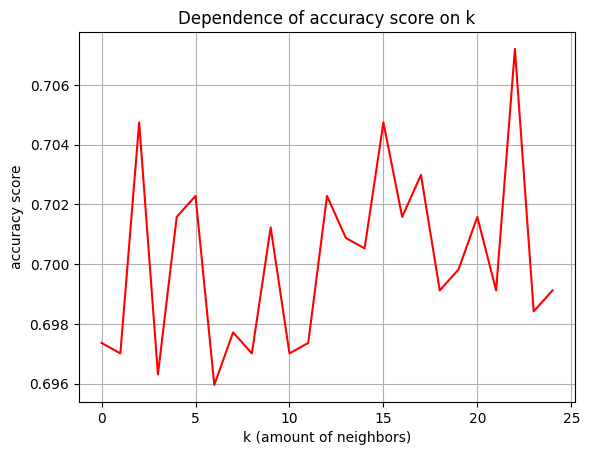

Если оценивать по accuracy, оптимальное количество деревьев равно 22
accuracy score для k = 22 равна 0.70721


In [20]:
from sklearn.ensemble import RandomForestClassifier
accuracy_array, f1_array = [], []
for i in np.arange(5, 30):
    new_model = RandomForestClassifier(n_estimators=i)
    new_model.fit(features_train, target_train)
    new_predictions = new_model.predict(features_validation_labeled)
    accuracy_array.append(accuracy_score(target_validation_labeled, new_predictions))

plt.figure()
plt.xlabel('k (amount of neighbors)')
plt.ylabel('accuracy score')
plt.title('Dependence of accuracy score on k')
plt.grid()
plt.plot(accuracy_array, c='red')
plt.show()


er_num1 = list(enumerate(accuracy_array, 0))
k_optimal_accuracy = max(er_num1, key=lambda i : i[1])
print('Если оценивать по accuracy, оптимальное количество деревьев равно', k_optimal_accuracy[0])
print(f'accuracy score для k = {k_optimal_accuracy[0]} равна', round(accuracy_array[k_optimal_accuracy[0]], 5))

Видно, что среднем accuracy score находится в пределах 0.71-0.72.

 ## Bert

In [21]:
def ch_str(string):
    if len(string) >= 512:
        return string[:512]
    else:
        return string

In [22]:
grid_table = pd.concat([train_data, validation_data_labeled])
bert_train_data = grid_table.copy()
bert_train_data['clean'] = train_data['clean'].apply(ch_str)
bert_res = bert_train_data.loc[:,['clean', 'label']]
bert_res

,clean,label
0,Джеймс Бадди Макгирт тренер Дадашева упрашивал...,0
1,За всю нашу долгую карьеру нам довелось играть...,0
2,Ранее декабря толпа болельщиков перекрыла движ...,0
3,В субботу июля года на арене СК Олимпийский в ...,0
4,Представитель талибов Забиулла Муджахид в твит...,-1
...,...,...
2840,Дональд Трамп младший со сторонником избрания ...,0
2841,Арпайо ожидал приговора он мог быть приговорен...,0
2842,ноября сайт начал публикацию более тыс секретн...,-1
2843,не будет запрещать песню Дин дон ведьма умерла...,0


In [23]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = bert_res['clean'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    max_len = max(len(i), max_len)
round_ = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(round_ != 0, 1, 0)

In [24]:
model = transformers.BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(round_.shape[0] // batch_size)):
    batch = torch.LongTensor(round_[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size *(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())